## 0.Data preparation

In [1]:
import pandas as pd

path = "/app/Final/code"
# path = "."
# This is the dataset processed from the midterm
train_size = 14993
data_df = pd.read_csv(path + "/data/data_df_proc.csv")[:train_size]
data_df.head()

cols_to_drop = ["Name", "RescuerID", "VideoAmt", "Description", "PetID", "PhotoAmt"]
to_drop_columns = [
    "PetID",
    "Name",
    "RescuerID",
    "Description",
    "BreedName_full",
    "Breed1Name",
    "Breed2Name",
]
data_df.drop(cols_to_drop + to_drop_columns, axis=1, inplace=True)

# Fill missing values with mean
data_df.fillna(data_df.mean(), inplace=True)

# Embedding the categorical variables using nn.Embedding
cat_cols = [
    "Breed1",
    "Breed2",
    "Color1",
    "Color2",
    "Color3",
    "Gender",
    "State",
    "Breed_full",
    "Color_full",
    "hard_interaction",
]


In [2]:
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
for cat_col in cat_cols:
    label_encoders[cat_col] = LabelEncoder()
    data_df[cat_col] = label_encoders[cat_col].fit_transform(data_df[cat_col])


emb_c = {n: len(col.unique()) for n, col in data_df.items() if n in cat_cols}
emb_cols = emb_c.keys()  # names of columns chosen for embedding
emb_szs = [
    (c, min(10, (c + 1) // 2)) for _, c in emb_c.items()
]  # embedding sizes for the chosen columns

# Split data into train and validation by AdoptionSpeed and stratify
from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(
    data_df, test_size=0.2, random_state=42, stratify=data_df["AdoptionSpeed"]
)

X_train = train_df.drop(columns="AdoptionSpeed")
y_train = train_df["AdoptionSpeed"]
X_valid = valid_df.drop(columns="AdoptionSpeed")
y_valid = valid_df["AdoptionSpeed"]

n_cont = len(X_train.columns) - len(emb_cols)  # number of continuous columns


In [3]:
from network_setting import *
model = PetFinderModel(emb_szs, n_cont)
device = get_default_device()
to_device(model, device)

PetFinderModel(
  (embeddings): ModuleList(
    (0): Embedding(176, 10)
    (1): Embedding(135, 10)
    (2): Embedding(3, 2)
    (3-4): 2 x Embedding(7, 4)
    (5): Embedding(6, 3)
    (6): Embedding(14, 7)
    (7): Embedding(812, 10)
    (8): Embedding(63, 10)
    (9): Embedding(142, 10)
  )
  (lin1): Linear(in_features=228, out_features=512, bias=True)
  (lin2): Linear(in_features=512, out_features=256, bias=True)
  (lin3): Linear(in_features=256, out_features=128, bias=True)
  (lin4): Linear(in_features=128, out_features=32, bias=True)
  (lin5): Linear(in_features=32, out_features=1, bias=True)
  (bn1): ReLU()
  (bn2): ReLU()
  (bn3): ReLU()
  (bn4): ReLU()
  (output): ReLU()
  (emb_drop): Dropout(p=0.2, inplace=False)
  (drops): Dropout(p=0.1, inplace=False)
)

episode: 0
training loss: 3.601, kappa: 0.008
validation loss: 3.585, kappa: 0.000
episode: 50
training loss: 1.369, kappa: 0.094
validation loss: 1.381, kappa: 0.050
episode: 100
training loss: 1.341, kappa: 0.110
validation loss: 1.351, kappa: 0.125
episode: 150
training loss: 1.320, kappa: 0.129
validation loss: 1.349, kappa: 0.121
episode: 200
training loss: 1.293, kappa: 0.151
validation loss: 1.339, kappa: 0.128
episode: 250
training loss: 1.268, kappa: 0.179
validation loss: 1.320, kappa: 0.150
episode: 300
training loss: 1.230, kappa: 0.206
validation loss: 1.324, kappa: 0.139
episode: 350
training loss: 1.201, kappa: 0.242
validation loss: 1.300, kappa: 0.175
episode: 400
training loss: 1.181, kappa: 0.259
validation loss: 1.309, kappa: 0.163
episode: 450
training loss: 1.148, kappa: 0.281
validation loss: 1.311, kappa: 0.171
episode: 500
training loss: 1.131, kappa: 0.302
validation loss: 1.315, kappa: 0.186
episode: 550
training loss: 1.102, kappa: 0.334
validation loss: 1.3

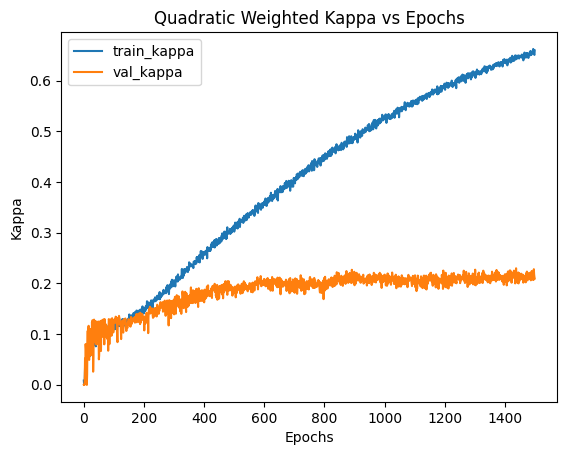

In [4]:
train_ds = PetFinderData(X_train, y_train, emb_cols)
valid_ds = PetFinderData(X_valid, y_valid, emb_cols)

# Get data into device
batch_size = 512
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=True)

train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)


# Train model
epochs = 1500
history = train_loop(
    model, epochs=epochs, lr=0.00005, wd=0.0001, train_dl=train_dl, valid_dl=valid_dl
)
# Save model
torch.save(model.state_dict(), "./model-stratify-10.pt")
# Save history
history = np.array(history)
np.save("./history.npy", history)

import matplotlib.pyplot as plt

# range(epochs)
plt.plot(range(epochs), history[:, 0], label="train_loss")
plt.plot(range(epochs), history[:, 2], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.legend()
# plt.show()
plt.savefig(path + "/figure/loss-statify-10.png")

plt.clf()
plt.plot(range(epochs), history[:, 1], label="train_kappa")
plt.plot(range(epochs), history[:, 3], label="val_kappa")
plt.xlabel("Epochs")
plt.ylabel("Kappa")
plt.title("Quadratic Weighted Kappa vs Epochs")
plt.legend()
# plt.show()
plt.savefig(path + "/figure/kappa-stratify-10.png")